In [1]:
import numpy as np # primary math library
import matplotlib.pyplot as plt # primary plotting library
%matplotlib inline

import nelpy as nel # should be installed using pip install nelpy

import warnings
#warnings.filterwarnings("ignore") # useful to prevent excess nelpy warnings

/home/kemerelab/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
# dataroot = '/Users/ckemere/Development/Data/Frank/';
dataroot = '/home/kemerelab/Data/' # There's one in both this and ./motivational-t/ !

In [3]:
import os

filename = os.path.join(dataroot,'FullMVDMData.nel')
import nelpy.io
jar = nel.load_pkl(filename)

data = jar.Data
TrackData = jar.TrackData
del jar


In [4]:
data.keys()

dict_keys(['R042', 'R044', 'R050', 'R064'])

# Calculate tuning curves for all neurons for all animals and days

In [5]:
from numpy import unravel_index
    
sigma_500ms = 0.5 # Smoothing for speed calculation
# Bin sizes are 500 ms, and then we slide
# ds_run = 0.250 # 250 ms
ds_25ms = 0.025

# sigma_250ms = 0.25 # 250 ms spike smoothing

min_duration = 1 # require that estimation periods be at least 1 second long

# Smoothing standard deviation
sigma_tc = 2.5 # tuning curve smoothing std in cm
min_spikes = 5

PFCenters = {}
TuningCurves = {}

for anim, animdata in data.items():
    PFCenters[anim] = {}
    TuningCurves[anim] = {}
    
    for day, daydata in animdata.items():
        print(anim, day)
        S = daydata['spikes']
        pos = daydata['pos']

        x_extents = TrackData[anim]['XExtents'] # Read these off of maze figure above
        y_extents = TrackData[anim]['YExtents']

        nx = np.diff(x_extents)/5 # 5 cm bins
        ny = np.diff(y_extents)/5

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_500ms)

        # get_run_epochs is a utility function which wraps a speed threshold. This finds periods where the speed
        #   is greater than v2 and reaches at least a maximum of v1.
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            run_epochs = nel.utils.get_run_epochs(speed, v1=10, v2=5) # has to be at least 10 cm/s
            run_epochs = pos.support.intersect(run_epochs)  
            run_epochs = run_epochs.intersect(daydata['trial_iv'])

        st_run = S[run_epochs]

        # bin, smooth and re-bin:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            bst_run = st_run.bin(ds=ds_25ms)
            #bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma_250ms, inplace=True).rebin(w=ds_run/ds_50ms)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tc = nel.TuningCurve2D(bst=bst_run, extern=pos, 
                                   ext_xmin=x_extents[0], ext_xmax=x_extents[1], 
                                   ext_ymin=y_extents[0], ext_ymax=y_extents[1],
                                   ext_nx=nx, ext_ny=ny,
                                   sigma=None, min_duration=0.5)
                                   #sigma=sigma_tc, min_duration=1)

        TuningCurves[anim][day] = tc
        PFCenters[anim][day] = []

        for idx, pf in enumerate(tc.ratemap):
            placefield = pf.T
            peak = unravel_index(placefield.squeeze().argmax(),placefield.shape)
            PFCenters[anim][day].append([idx, placefield.max(), peak[0], peak[1]])

    


R042 2013-08-16
R042 2013-08-17
R042 2013-08-18
R042 2013-08-19
R042 2013-08-20
R042 2013-08-21
R044 2013-12-18
R044 2013-12-19
R044 2013-12-20
R044 2013-12-21
R044 2013-12-22
R044 2013-12-23
R050 2014-03-29
R050 2014-03-30
R050 2014-03-31
R050 2014-04-01
R050 2014-04-02
R050 2014-04-03
R064 2015-04-18
R064 2015-04-19
R064 2015-04-20
R064 2015-04-21
R064 2015-04-22
R064 2015-04-23


# Plot an example tuning curve

0.46313072411 28.0


/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


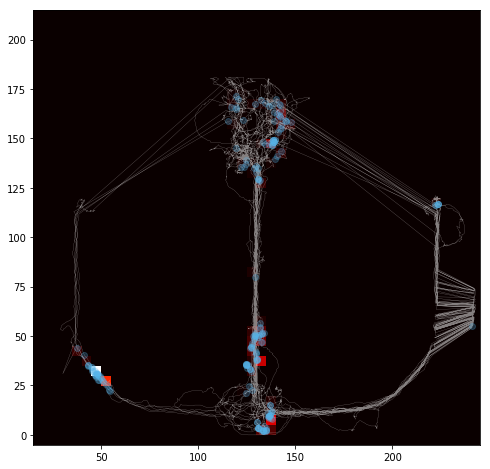

In [6]:
import nelpy.plotting as npl

anim = 'R064'
day = '2015-04-19'

tc = TuningCurves[anim][day]
xx_mid = tc.xbin_centers
yy_mid = tc.ybin_centers

S = data[anim][day]['spikes']
pos = data[anim][day]['pos']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_500ms)

# get_run_epochs is a utility function which wraps a speed threshold. This finds periods where the speed
#   is greater than v2 and reaches at least a maximum of v1.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    run_epochs = nel.utils.get_run_epochs(speed, v1=10, v2=5) # has to be at least 10 cm/s
    run_epochs = run_epochs.intersect(data[anim][day]['trial_iv'])


#runpos = pos[data[anim][day]['trial_iv'],:]
runpos = pos[run_epochs,:]
xvals, yvals = runpos.asarray().yvals

nidx = 5

print(S[runpos.support].n_spikes[nidx]/runpos.support.duration,
     tc.ratemap[nidx,:,:].max())
xspks, yspks = runpos.asarray(at=S[run_epochs,:].time[nidx]).yvals

placefield = tc.ratemap[nidx]

fig, ax = plt.subplots(1,1, figsize = (8, 8))
ax.set_aspect('equal')
npl.imagesc(x=xx_mid, y=yy_mid, data=placefield.T, cmap=plt.cm.hot, ax=ax)
ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
ax.plot(xspks, yspks, 'o', color=npl.colors.sweet.blue, alpha=0.25)



# Decode each ripple's total position and odds over maze zones

In [7]:
def calculate_shuffle_odds(swr, ratemap, left_pixels, right_pixels, n_shuffles=50):
    if swr.n_active == 0:
        return (np.nan, 0)

    NN = ratemap.shape[0]
    bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)
    left_odds = (bayes_estimate * left_pixels.T).sum()
    right_odds = (bayes_estimate * right_pixels.T).sum()

    true_odds = left_odds - right_odds

    shuf_odds = []
    for n in range(n_shuffles):
        shuf_rate = ratemap.copy()
        shuf_rate = shuf_rate[np.random.permutation(NN),:,:]
        shuf_est = -shuf_rate.sum(axis=0).T + np.log(shuf_rate.T).dot(swr.n_spikes)
        left_odds = (shuf_est * left_pixels.T).sum()
        right_odds = (shuf_est * right_pixels.T).sum()
        shuf_odds.append(left_odds - right_odds)
        
    return (true_odds, shuf_odds)


In [ ]:
TrackData['R064']

{'LeftArmRect': [150, -5, 250, 135],
 'RightArmRect': [5, -5, 105, 135],
 'XExtents': [15, 245],
 'YExtents': [-5, 215]}

In [ ]:
from joblib import Parallel, delayed
from scipy import stats
import time
from shapely.geometry import box, Point

RippleArmScores = {}
NNeuronShufs = 500

for anim, animdata in data.items():
    RippleArmScores[anim] = {}    
    for day, daydata in animdata.items():
        print(anim, day)
        t0 = time.time()

        ########################################################
        # Calculate pixel bins for left and right decoding areas
        nx = TuningCurves[anim][day].n_xbins
        ny = TuningCurves[anim][day].n_ybins
        xx_mid = TuningCurves[anim][day].xbin_centers
        yy_mid = TuningCurves[anim][day].ybin_centers
        
        left_box = box(*TrackData[anim]['LeftArmRect'])
        right_box = box(*TrackData[anim]['RightArmRect'])
        
        left_pixels = np.zeros((int(nx),int(ny)))
        right_pixels = np.zeros((int(nx),int(ny)))
        for ix, x in enumerate(xx_mid):
            for iy, y in enumerate(yy_mid):
                left_pixels[ix,iy] = left_box.contains(Point([x,y]))
                right_pixels[ix,iy] = right_box.contains(Point([x,y]))
        ########################################################

        t1 = time.time()
        print('Pixel areas decided', t1-t0, 's')

        swr_eps = data[anim][day]['event-candidates']
        S = data[anim][day]['spikes']        
        
        if (swr_eps.n_epochs < 20):
            continue
        
        RippleArmScores[anim][day] = {}
        
        RippleArmScores[anim][day]['RippleEpochs'] = swr_eps

        swrtimes = swr_eps.starts
        
        isi = np.insert(np.diff(swrtimes),0,-np.nan)
        RippleArmScores[anim][day]['TimeSinceLastRipple'] = isi

        print('Scoring starting')

        pos = daydata['pos']
        runpos = pos[data[anim][day]['trial_iv'],:]
        placecells = S[runpos.support,:].n_spikes/runpos.support.duration < 5
        swr_spikes = S.iloc[swr_eps,placecells]

        ratemap = TuningCurves[anim][day].ratemap
        ratemap = ratemap[placecells,:,:]

        results = Parallel(n_jobs=29)(delayed(calculate_shuffle_odds)(swr, ratemap, 
                                    left_pixels, right_pixels, n_shuffles=NNeuronShufs) for swr in swr_spikes)
        t2 = time.time()
        print('Done in ', t2-t1, 's')

        true_odds, shuf_odds = zip(*results)

        RippleArmScores[anim][day]['TrueOdds'] = true_odds
        RippleArmScores[anim][day]['OddsShuffles'] = shuf_odds

        shuf_ratio = []
        for idx, t in enumerate(true_odds):
            if not np.isnan(t):
                shuf_ratio.append(stats.percentileofscore(shuf_odds[idx],t))
            else:
                shuf_ratio.append(np.nan)
                
        shuf_ratio = np.array(shuf_ratio)
        RippleArmScores[anim][day]['TruePercentiles'] = shuf_ratio
        RippleArmScores[anim][day]['ScoreOfLastRipple'] = np.hstack([np.nan, shuf_ratio[:-1]])

        shuf_ratio2 = np.zeros(shuf_ratio.shape)
        shuf_ratio2[shuf_ratio > 75] = 1.0
        shuf_ratio2[shuf_ratio < 25] = -1.0
        RippleArmScores[anim][day]['TruePercentilesThresholded'] = shuf_ratio2
        RippleArmScores[anim][day]['ScoreOfLastRippleThresholded'] = np.hstack([0, shuf_ratio2[:-1]])
        
        print(len(isi), len(np.hstack([shuf_ratio[1:], np.nan])))
    

R042 2013-08-16
Pixel areas decided 0.056387901306152344 s
Scoring starting


/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Done in  42.5956974029541 s
1127 1127
R042 2013-08-17
Pixel areas decided 0.05639481544494629 s
Scoring starting


/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Done in  75.77747797966003 s
595 595
R042 2013-08-18
Pixel areas decided 0.05331873893737793 s
Scoring starting


/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


In [ ]:
RippleArmScores

# Plot an example event

In [ ]:
import seaborn as sns
from descartes.patch import PolygonPatch # pip install descartes

anim = 'R064'
day = '2015-04-18'

swr_eps = data[anim][day]['event-candidates']
S = data[anim][day]['spikes']        
pos = data[anim][day]['pos']

p = np.array(PFCenters[anim][day],dtype=int)
pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T

runpos = pos[data[anim][day]['trial_iv'],:]

ratemap = TuningCurves[anim][day].ratemap

placecells = (S[runpos.support,:].n_spikes/runpos.support.duration < 5) & (ratemap.max(axis=2).max(axis=1) > 1)
print(placecells.sum())
swr_spikes = S.iloc[swr_eps,placecells]

ratemap = ratemap[placecells,:,:]

ex = 17

swr = swr_spikes[ex]
print(swr.n_active)

fig, ax = plt.subplots(1,3,figsize=(15,5))

xvals, yvals = runpos.simplify(n_points=5000).asarray().yvals
ax[0].plot(xvals, yvals, lw=0.25, color='gray', alpha=0.5)

pc_indices = np.argwhere(placecells).squeeze()
for nidx, n in enumerate(swr.n_spikes):
    if n > 0:
        pidx = pc_indices[nidx]
        ax[0].plot(pfcenters[pidx][0],pfcenters[pidx][1],'o',markersize=3*n);
    
bayes_estimate = np.log(ratemap.T).dot(swr.n_spikes)
# bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)

left_odds = (bayes_estimate * left_pixels.T).sum()
right_odds = (bayes_estimate * right_pixels.T).sum()

print(left_odds, right_odds)
true_odds = left_odds - right_odds

ax[1].set_aspect('equal')
ax[1], img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate, cmap=plt.cm.RdBu_r, ax=ax[1])
_ = ax[1].add_patch(PolygonPatch(right_box,alpha=0.1));
_ = ax[1].add_patch(PolygonPatch(left_box,alpha=0.1));

plt.colorbar(img, ax=ax[1])

sns.distplot(RippleArmScores[anim][day]['OddsShuffles'][ex], ax=ax[2])
ax[2].plot(RippleArmScores[anim][day]['TrueOdds'][ex]*np.ones(2),np.array([0,0.0005]))
ax[2].set_title('Percentile = {}'.format(RippleArmScores[anim][day]['TruePercentiles'][ex]))


In [ ]:
ds = 0.01 # 10 millisecond bins should be ok?

RipEventData = {}
for anim, animdata in data.items():
    RipEventData[anim] = {}
    for day, daydata in animdata.items():
        print(anim, day)
        swr_eps = data[anim][day]['event-candidates']
        expanded_support = nel.EpochArray([swr_eps.centers[0]-5,swr_eps.centers[-1]+5])
        swr_events = nel.SpikeTrainArray(swr_eps.centers, support=expanded_support)    
        binned_swr_events = nel.BinnedSpikeTrainArray(swr_events, ds=ds)
        RipEventData[anim][day] = {}
        RipEventData[anim][day]['Scores'] = (RippleArmScores[anim][day]['TruePercentiles'] - 50)/100
        RipEventData[anim][day]['TimeSeriesLength'] = binned_swr_events.data.squeeze().shape[0]
        RipEventData[anim][day]['EventInds'] = np.argwhere(binned_swr_events.data.squeeze()==1)


# Generate shuffled event autocorrelations

In [ ]:
def autocorrelate(x, NA=10000):
    autocor = np.zeros(NA)
    for lag in range(NA):
        if lag == 0:
            autocor[lag] = np.inner(x, x)/len(x)
        else:
            autocor[lag] = np.inner(x[:-lag], x[lag:]) / len(x[lag:])
            
    return autocor

## "Raw" autocorrelations - no time, just event numbers!

In [ ]:
fig, axs = plt.subplots(24,2,figsize=(15,15))


idx = 0;
for anim, animdata in RippleArmScores:
    for day, daydata in RippleArmScores[anim].items():
        print(anim, day)
        scores = (RippleArmScores[anim][day]['TruePercentiles']-50)/100
        scores = scores[~np.isnan(scores)]
        raw_autocor = autocorrelate(scores)

        sns.distplot(scores,100,ax=axs[idx,0])

        NShufRaw = 50
        RawShuf = np.zeros((raw_autocor.shape[0],NShufRaw))
        for i in range(NShufRaw):
            RawShuf[:,i] = autocorrelate(np.random.permutation(scores))

        ax = axs[idx,1]
        ax.semilogx(raw_autocor)
        ax.semilogx(np.percentile(RawShuf,90,axis=1))
        ax.semilogx(np.percentile(RawShuf,10,axis=1))
        ax.set_ylim(-0.025+raw_autocor[0],0.025+raw_autocor[0])
        ax.grid(True)
        ax.set_title('{},{}'.format(anim,day))

        idx = idx + 1

## Actual autocorrelations with events pasted into a big time vector

In [ ]:
NA = 10000
day = '2015-04-22'

score_time_series = np.zeros(RipEventData[anim][day]['TimeSeriesLength'])
score_time_series[RipEventData[anim][day]['EventInds']] = np.expand_dims(RipEventData[anim][day]['Scores'],1)
smoothed_scoreTS = scipy.ndimage.filters.gaussian_filter1d(score_time_series,sigma=sigma)

autocor = autocorrelate(smoothed_scoreTS.squeeze(),NA=NA)

fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(smoothed_scoreTS[400:2000])
ax[0].plot(score_time_series[400:2000])

ax[1].semilogx(np.arange(NA-1)*ds, autocor[1:]*(1/ds)*(1/ds))
ax[1].set_ylim(-0.01,0.01)
ax[1].grid(True)


In [ ]:
def shuffle_autocorrelation(event_indices, event_values, nbins, sigma):
    shuf_time_series = np.zeros(nbins)
    shuf_time_series[event_indices] = np.expand_dims(np.random.permutation(event_values),1)
    smoothed_shuf = scipy.ndimage.filters.gaussian_filter1d(shuf_time_series,sigma=sigma)
    return autocorrelate(smoothed_shuf.T)
    

In [ ]:
import time

NShufs = 500

for anim, animdata in RipEventData.items():
    if (anim != 'R064'):
        continue
    for day, daydata in animdata.items():
        print(anim,day)

        true_scores = daydata['Scores']
        event_indices = daydata['EventInds']
        TSL = RipEventData[anim][day]['TimeSeriesLength']

        
        score_time_series = np.zeros(TSL)
        score_time_series[event_indices] = np.expand_dims(true_scores,1)
        smoothed_scoreTS = scipy.ndimage.filters.gaussian_filter1d(score_time_series,sigma=sigma)
        actual_autocor = autocorrelate(smoothed_scoreTS.squeeze(),NA=NA)
        RipEventData[anim][day]['ActualAutocorrelations'] = actual_autocor
        
        shuf_autocor = np.zeros((NA,NShufs))

        t1 = time.time()
        for i in range(NShufs):
            if (i % 50 == 0):
                print(i)
            shuf_autocor[:,i] = shuffle_autocorrelation(event_indices, true_scores, TSL, sigma)
        t2 = time.time()
        
        RipEventData[anim][day]['ShuffledAutocorrelations'] = [
            np.mean((shuf_autocor),axis=1),
            np.percentile((shuf_autocor),95,axis=1),
            np.percentile((shuf_autocor),5,axis=1),
        ]

        print('Single thread time: {}'.format(t2-t1))
    

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(10,15))
ax = ax.flatten()
idx = 0
for day, daydata in RippleArmScores[anim].items():
    print(anim, day)
    actual = RipEventData[anim][day]['ActualAutocorrelations']
    top = RipEventData[anim][day]['ShuffledAutocorrelations'][1]
    middle = RipEventData[anim][day]['ShuffledAutocorrelations'][0]
    bottom = RipEventData[anim][day]['ShuffledAutocorrelations'][2]

    ax[idx].semilogx(np.arange(NA)*ds, actual*(1/ds)*(1/ds))
    ax[idx].semilogx(np.arange(NA)*ds, top*(1/ds)*(1/ds))
    ax[idx].semilogx(np.arange(NA)*ds, bottom*(1/ds)*(1/ds))

    ax[idx].set_xlim(0.1,100)
    idx = idx + 1



In [ ]:
anim = 'R064'
day = '2015-04-22'
actual = RipEventData[anim][day]['ActualAutocorrelations']
top = RipEventData[anim][day]['ShuffledAutocorrelations'][1]
middle = RipEventData[anim][day]['ShuffledAutocorrelations'][0]
bottom = RipEventData[anim][day]['ShuffledAutocorrelations'][2]

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.semilogx(np.arange(NA)*ds, actual*(1/ds)*(1/ds))
ax.semilogx(np.arange(NA)*ds, top*(1/ds)*(1/ds))
ax.semilogx(np.arange(NA)*ds, bottom*(1/ds)*(1/ds))

ax.set_xlim(0.1,100)
ax.set_ylim(-0.02,0.02)
